# Hiv Model

Mellie Zito

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
'''Greek Alphabet:
Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, 
Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, 
Σ σ/ς, Τ τ, Υ υ, Φ φ, 
Χ χ, Ψ ψ, and Ω ω.
'''

'Greek Alphabet:\nΑ α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, \nΛ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, \nΣ σ/ς, Τ τ, Υ υ, Φ φ, \nΧ χ, Ψ ψ, and Ω ω.\n'

In [3]:
def make_system(Γ, τ, μ, β, ρ, α, δ, σ, π):
    """Make a system object for the SIR model.
    R is lymphocytes
    L is latently infected cells
    E is actively infected cells
    V is free virions
    
    Γ is the rate at which new, uninfected lymphocytes (R) arise
    τ is the proportion of uninfected lymphocytes (R) that are activated
    μ is the rate uninfected lymphocytes (R) are removed by HIV-independent death
    β is the rate of infection (lymphocytes to virions)
    ρ is the proportion of cells that become latently infected (L)
    α is the rate of removal of latently infected cells (L) by activation
    δ is the rate of death of actively infected cells (E)
    σ is the rate of removal of free virions (V)
    π is rate of production of virions (V) by an actively infected cell (E)
    
    returns: System object
    """
    init = State(R=1000, L=0, E=0,V=100)

    t0 = 0
    t_end = 120

    return System(init=init, t0=t0, t_end=t_end,
                  Γ=Γ, τ=τ, μ=μ, β=β, ρ=ρ, α=α, δ=δ, σ=σ, π=π)

In [4]:
def plot_results_single(V):
    """Plot the results of a SIR model.
    
    V: TimeSeries
    
    """
    plot(V, '-', label='Virions')
    
    decorate(xlabel='Time (days)',
             ylabel='Population')

In [5]:
def plot_results(R, L, E):
    """Plot the results of a SIR model.
    
    R: TimeSeries
    L: TimeSeries
    E: TimeSeries
    V: TimeSeries
    
    """
    plot(R, '--', label='Lymphocytes')
    plot(L, '-', label='Latently affected cells')
    plot(E, '-', label='Actively infected cells')
    #plot(V, '-', label='Virions')
    
    decorate(xlabel='Time (days)',
             ylabel='Population')

In [6]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (R, L, E, V)
    t: time
    system: System object
    
    returns: State (RLEV)
    """
    unpack(system)
    
    r, l, e, v = state

    #dr/dt = Γτ - μr - βrv
    r_arise = Γ * τ 
    r_death = μ * r 
    r_infection = β * r * v
    
    #dl/dt = ρβRV - μL - αL
    l_infection = ρ * β * r * v
    l_death = μ * l
    l_activation = α * l
    
    #de/dt = (1-ρ)βRV + αL - δE
    e_generation = (1-ρ)* β * r * v #actively infected cells are generated immediately after infection
    e_activation = α * l
    e_death = δ * e
    
    #dv/dt = (pi)E - σV  
    v_production = π * e
    v_death = σ * v
    
    r += r_arise - r_death - r_infection
    l += l_infection - l_death - l_activation
    e += e_generation + e_activation - e_death
    v += v_production - v_death
    
    return State(R=r, L=l, E=e, V=v)

In [7]:
#slope_func just returns differential equations, doesnt update state
#system = make_system(0.333, 0.25)
#print(slope_func(system.init, system.t0, system))
#results, details = run_ode_solver(system, slope_func, max_step=2)
#details
#plot_results(results.S, results.I, results.R)

In [8]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [9]:
system = make_system(1.36, 0.2, 0.00136, 0.00027, 0.1, 0.036, 0.33, 2, 100)
#make_system(Γ, τ, μ, β, ρ, α, δ, σ, π)
results = run_simulation(system, update_func)
results.head()

,R,L,E,V
0,1000,0,0,100
1,971.912,2.7,24.3,-100
2,997.104,-0.0250344,-7.23926,2530
3,314.898,68.0881,608.158,-3253.93
4,591.399,37.8786,160.926,64069.8


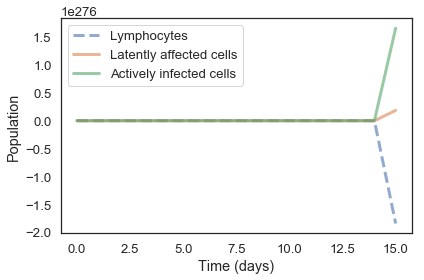

In [10]:
plot_results(results.R, results.L, results.E)

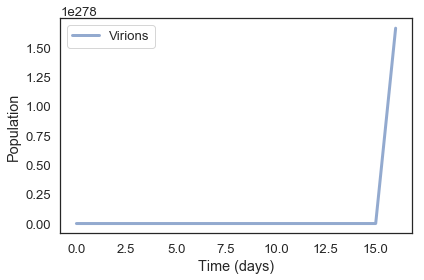

In [11]:
plot_results_single(results.V)